# Определение перспективного тарифа для телеком компании

## Описание проекта

Выполнение задачи для оператора связи. Сущесствует два тарифных плана «Смарт» и «Ультра». Необходимо выяснить, какой тариф приносит больше денег.

Есть небольшая выборка клиентов и данные о них: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание данных

    Таблица users (информация о пользователях):
        user_id — уникальный идентификатор пользователя
        first_name — имя пользователя
        last_name — фамилия пользователя
        age — возраст пользователя (годы)
        reg_date — дата подключения тарифа (день, месяц, год)
        churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
        city — город проживания пользователя
        tariff — название тарифного плана
        
    Таблица calls (информация о звонках):
        id — уникальный номер звонка
        call_date — дата звонка
        duration — длительность звонка в минутах
        user_id — идентификатор пользователя, сделавшего звонок
        
    Таблица messages (информация о сообщениях):
        id — уникальный номер сообщения
        message_date — дата сообщения
        user_id — идентификатор пользователя, отправившего сообщение
        
    Таблица internet (информация об интернет-сессиях):
        id — уникальный номер сессии
        mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
        session_date — дата интернет-сессии
        user_id — идентификатор пользователя
        
    Таблица tariffs (информация о тарифах):
        tariff_name — название тарифа
        rub_monthly_fee — ежемесячная абонентская плата в рублях
        minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
        messages_included — количество сообщений в месяц, включённых в абонентскую плату
        mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
        rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
        rub_per_message — стоимость отправки сообщения сверх тарифного пакета
        rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Выполнение проекта

1. [Открыли файл с данными и изучили общую информацию](#step_1)

2. [Подготовка данных](#step_2)
    - Привели данные к нужным типам;
    - Нашли и исправьте ошибки в данных.
3. [Посчитать и добавить требуемые данные](#step_3)   
    - количество сделанных звонков и израсходованных минут разговора по месяцам;
    - количество отправленных сообщений по месяцам;
    - объем израсходованного интернет-трафика по месяцам;
    - помесячную выручку с каждого пользователя.
4. [Анализ данных](#step_4) 
    - анализ количества звонков, сообщений и интернет-трафика для клиентов;
    - анализ среднего значения звонков, сообщений, интернет-трафика;
    - анализ среднего отклонения звонков, сообщений, интернет-трафика;
    - анализ дисперсии звонков, сообщений, интернет-трафика.
5. [Проверка гипотез](#step_5) 
    - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
    - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
6. [Общий вывод](#step_6)    

### Импортирование библиотек и выгрузка данных

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import shapiro

Выгрузка данных <a id='step_1'></a>

In [2]:
df_calls = pd.read_csv('')
df_internet = pd.read_csv('')
df_messages = pd.read_csv('')
df_tariffs = pd.read_csv('')
df_users = pd.read_csv('')

### Подготовка данных

<b>Информация о звонках</b> <a id='step_2'></a>

In [3]:
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format = '%Y-%m-%d')
df_calls.isna().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

В датафрейме с информацией о званках пользователей нет пропусков, но есть значения типа 0.0. Их предстоит заменить.
Также есть дата и её тип был заменён на соответствующий.

In [5]:
# замена длительности нулевых звонков на 1
df_calls.loc[df_calls['duration'] == 0, 'duration'] = 1
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,1.00,1000
1,1000_1,2018-08-17,1.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Заменили нулевые значения на 1, так как считаем, что провайдер округляет в большую сторону.

<b>Информация об интернет-сессиях</b>

In [6]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')
df_internet.isnull().sum()
#del df_internet[Unnamed: 0']

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

В датафрейме с информацией об интернет-сессиях нет пропусков, но есть лишний столбец, который можно удалить(он дублирует номера строк). Есть столбец с датами, его преобразовали в соответствующий формат.

<b>Информация о сообщениях</b>

In [8]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

В датафрейме с информацией о сообщениях нет пропусков. Есть столбец с датами, его преобразовали в соответствующий формат.

<b>Информация о тарифах</b>

In [10]:
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В датафрейме с информацией о тарифах всё хорошо.

<b>Информация о пользователях</b>

In [11]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [12]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format = '%Y-%m-%d')
df_users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

В датафрейме с информацией о пользователях есть пропуски. Есть столбец с датами, его преобразовали в соответствующий формат.


### Посчитать и добавить требуемые данные

<b>Добавили в датасеты недостающие столбцы</b> <a id='step_3'></a>

In [13]:
# Добавление столбца с месяцами, в которые проходили операции
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

In [14]:
df_calls['duration'] = df_calls['duration'].apply(np.ceil)
df_internet['mb_used'] = (df_internet['mb_used'] / 1024).apply(np.ceil)

In [15]:
# Подсчёт звонков, сообщений и интернет-трафика по месяцам для каждого клиента
calls_grouped = df_calls.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index()
internet_grouped = df_internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()
messages_grouped = df_messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()

In [16]:
# Объединяем дадасеты с информацией о пользователях и тарифах
df = df_users.merge(df_tariffs, left_on = 'tariff', right_on = 'tariff_name', how = 'outer')
# Объединяем все остальные дадасеты 
df = df.merge(calls_grouped, on = 'user_id', how = 'outer')
df = df.merge(internet_grouped, on = ['user_id', 'month'], how = 'outer')
df = df.merge(messages_grouped, on = ['user_id', 'month'], how = 'outer')
df['id'] = df['id'].fillna(0)
df['duration'] = df['duration'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,month,duration,mb_used,id
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,ultra,5.0,164.0,4.0,22.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,ultra,6.0,187.0,49.0,60.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,ultra,7.0,346.0,28.0,75.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,ultra,8.0,418.0,27.0,81.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,ultra,9.0,478.0,26.0,57.0


Создали датасет, объединяющий все необходимые нам данные по пользователям. Теперь данные в нём сгруппированы по пользователям и месяцам, посчитаны используемые ими минуты разговоров, собщения и интернет трафик.

In [17]:
# Функция определения вырукчки с клиента
def profit(row):
    calls_profit = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if calls_profit < 0 :
        calls_profit = 0
    messages_profit = (row['id'] - row['messages_included']) * row['rub_per_message']
    if messages_profit < 0 :
        messages_profit = 0
    internet_profit = (row['mb_used'] - (row['mb_per_month_included']/1024)) * row['rub_per_gb']
    if internet_profit < 0 :
        internet_profit = 0    
    return   calls_profit + messages_profit + internet_profit + row['rub_monthly_fee']

In [18]:
# Добавление столбца с выручкой для каждого клиента
df['profit'] = df.apply(profit, axis = 1)
df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,...,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,month,duration,mb_used,id,profit
0,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,...,1950.0,150.0,1.0,1.0,ultra,5.0,164.0,4.0,22.0,1950.0
1,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,...,1950.0,150.0,1.0,1.0,ultra,6.0,187.0,49.0,60.0,4800.0
2,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,...,1950.0,150.0,1.0,1.0,ultra,7.0,346.0,28.0,75.0,1950.0
3,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,...,1950.0,150.0,1.0,1.0,ultra,8.0,418.0,27.0,81.0,1950.0
4,1000,52.0,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000.0,30720.0,...,1950.0,150.0,1.0,1.0,ultra,9.0,478.0,26.0,57.0,1950.0


В датасет добавили столбец с выручкой с каждого клиента в месяц в соответствии с его тарифом и затратами услуг.


### Анализ данных

<b>Рассчёт статистических параметров: среднее, дисперсия, стандартное отклонение</b><a id='step_4'></a>

In [19]:
# Статистические параметры по всему дадасету
df[['duration','mb_used','id']].describe().style.format('{:.2f}')

,duration,mb_used,id
count,3222.00,3222.00,3222.00
mean,462.42,41.01,38.19
std,248.68,16.72,36.15
min,0.00,0.00,0.00
25%,289.25,31.00,9.00
50%,455.00,42.00,30.00
75%,605.00,52.00,57.00
max,1727.00,101.00,224.00


В среднем на разговоры в месяц у людей уходит около 462 минут, 41Гб. интернет-трафика, 38 смс сообщений.

In [20]:
# Статистические параметры по каждому пользователю отдельно
df_grouped = df.groupby(['user_id'])['duration','mb_used','id'].agg({'mean','var','std'})
df_grouped.head()

duration                          mb_used                        \
                  var         std     mean         var        std       mean   
user_id                                                                        
1000     11330.696429  106.445744  330.125  153.142857  12.375090  26.000000   
1001        98.000000    9.899495  437.000   72.000000   8.485281  41.000000   
1002      2868.666667   53.559935  223.000   73.904762   8.596788  42.714286   
1003     51965.200000  227.958768  782.800   25.700000   5.069517  21.200000   
1004      1658.571429   40.725562  128.000   59.125000   7.689278  36.375000   

                 id                    
                var        std   mean  
user_id                                
1000     337.142857  18.361450   62.0  
1001       0.000000   0.000000    0.0  
1002      20.333333   4.509250   10.0  
1003     530.000000  23.021729   76.0  
1004     669.142857  25.867796  149.0

<b>Анализ средних значений</b>

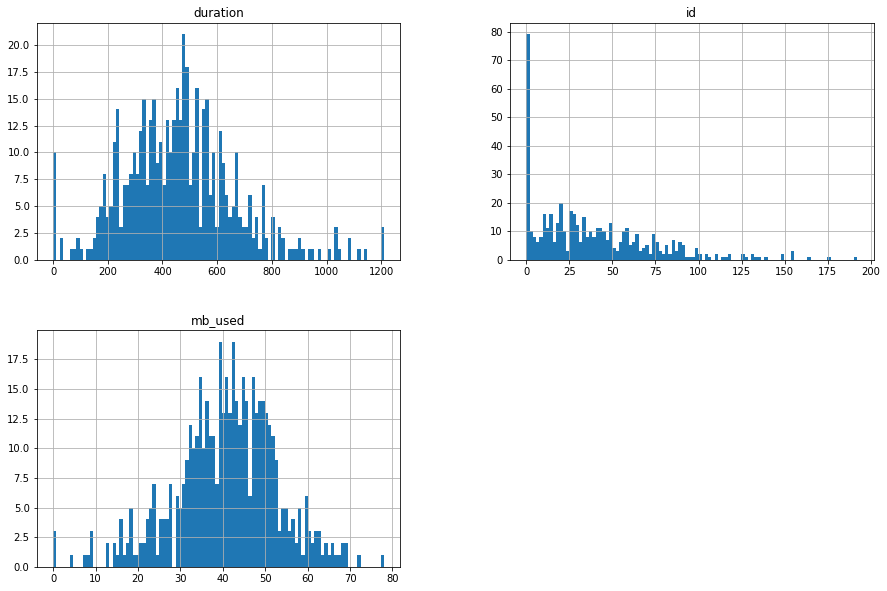

In [21]:
# Группировка данных по пользователям и анализ среднего значения
df_mean = df.groupby(['user_id'])['duration','mb_used','id'].mean()
df_mean.hist(bins = 100, figsize = (15,10))
plt.show()

Среднее значение длительности звонков имеет распределение похожее на нормальное, немного смещено влево (чаще всего тратят около 440 минут в месяц).

Среднее значение использования смс сообщений имеет распределение похожее на экспоненциальное (многие пользователи не используют смс сообщения).

Среднее значение используемых мегабайт имеет нормальное распределение(чаще используют около 16 Гб в месяц).

<b>Анализ стандартного отклонения</b>

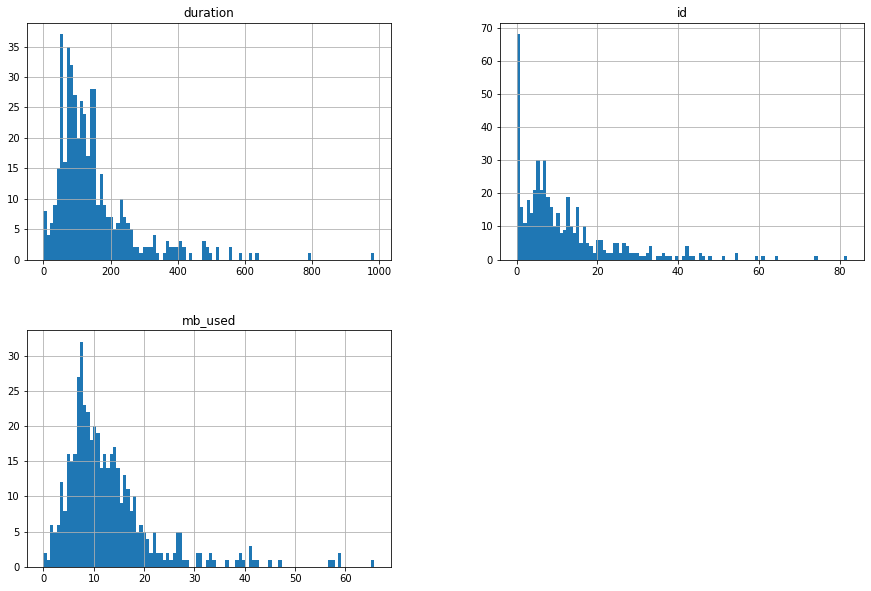

In [22]:
# Группировка данных по пользователям и анализ стандарнтного отклонения
df_std = df.groupby(['user_id'])['duration','mb_used','id'].std()
df_std.hist(bins = 100, figsize = (15,10))
plt.show()

Стандартное отклонение длительности звонков имеет распределение похожее на нормальное, смещённое влево.

Стандартное отклонение использования смс сообщений имеет распределение похожее на экспоненциальное.

Стандартное отклонение используемых мегабайт имеет распределение похожее на нормальное, немного смещено влево.

<b>Анализ дисперсии</b>

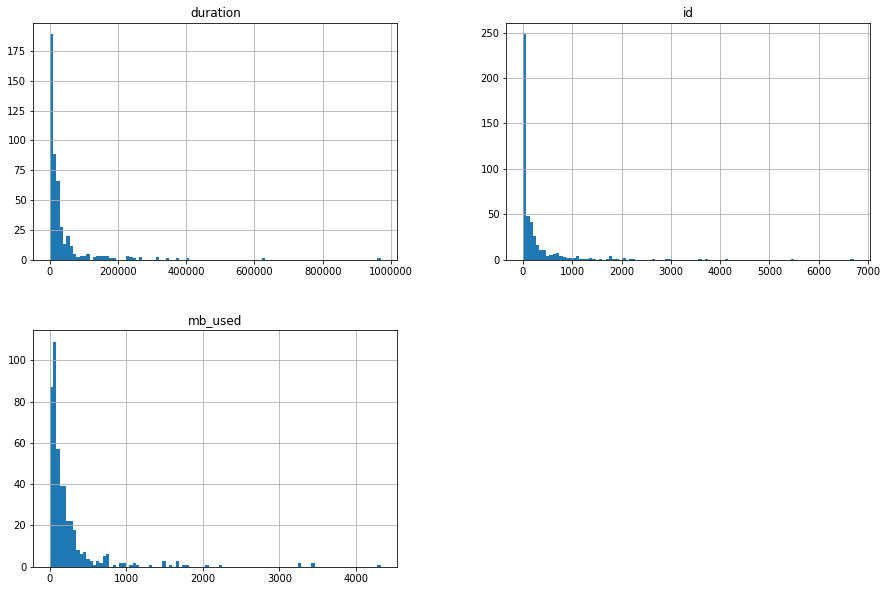

In [23]:
# Группировка данных по пользователям и анализ дисперсии
df_var = df.groupby(['user_id'])['duration','mb_used','id'].var()
df_var.hist(bins = 100, figsize = (15,10))
plt.show()

Дисперсии по всем исследуемым столбцам имеют распределение, похожее на экспоненциальное.



<b>Анализ выручки по тарифам</b>

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


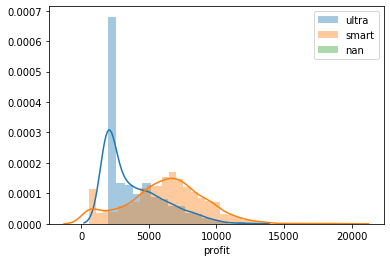

In [24]:
tariff_list = ['smart','ultra']
for tariff in df['tariff'].unique():
    current = df.query('tariff == @tariff')
    sns.distplot(current['profit'], label = tariff)
plt.legend()    
plt.show()

Из графика выше видно, что прибыль по тарифу ultra выше, чем по тарифу smart.

### Проверка гипотез

<b>Формулирование гипотезы о пользователях различных тарифов и её проверка</b><a id='step_5'></a>

In [25]:
# Разделили на два дадасета по тарифам и сгрупировали данные по пользователям и месяцам, выделили прибыль
smart_profit = df.query('tariff == "smart"')['profit']
ultra_profit = df.query('tariff == "ultra"')['profit']

Нулевая гипоетеза: средняя выручка пользователей тарифов smart и ultra равны. 

Уровень значимости — допустимая для данной задачи вероятность ошибки первого рода, то есть того, что гипотеза на самом деле верна, но будет отвергнута процедурой проверки. Критический уровень статистической значимости alpha выбрали 0,05.

Проверка выполняется с помошью критерия Стьюдента, так как есть две выборки, они независимы и надо сравнить средние значения выборок.

In [26]:
alpha = 0.05
results = st.ttest_ind(ultra_profit, smart_profit)
print('p-значение:',results.pvalue )
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, выручка отличается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выручка равна")

p-значение: 4.6037233369168e-110
Отвергаем нулевую гипотезу, выручка отличается


После применения теста Стьюдента смогли отвергнуть нулевую гипотезу о том, что средняя выручка по тарифам smart и ultra равны.

<b>Формулирование гипотезы о пользователях в москве и регионах</b>

In [27]:
# Разделили на два дадасета по городам - москва и регионы
moscow_profit = df.query('city == "Москва"')['profit']
not_moscow_profit = df.query('city != "Москва"')['profit']
moscow_profit = moscow_profit.fillna(0)
not_moscow_profit = not_moscow_profit.fillna(0)

Нулевая гипоетеза: средняя выручка пользователей в Москве и регионах равны. 

Уровень значимости — допустимая для данной задачи вероятность ошибки первого рода, то есть того, что гипотеза на самом деле верна, но будет отвергнута процедурой проверки. Критический уровень статистической значимости alpha выбрали 0,05.

Проверка выполняется с помошью критерия Стьюдента, так как есть две выборки, они независимы и надо сравнить средние значения выборок.

In [28]:
alpha = 0.05
results_2 = st.ttest_ind(moscow_profit, not_moscow_profit)
print('p-значение:',results_2.pvalue )
if (results_2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, выручка отличается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выручка равна")

p-значение: 0.6486588944919734
Не получилось отвергнуть нулевую гипотезу, выручка равна


После применения теста Стьюдента не была отклонена нулевая гипотеза о том, что выручка в Москве и регионах равна. 



0.002916777835702478 1.3271293337937916e-29


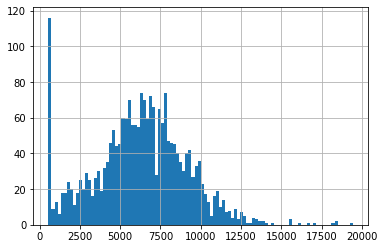

In [29]:
from scipy.stats import normaltest

stat, p_1 = normaltest(smart_profit)
stat, p_2 = normaltest(ultra_profit)
print(p_1, p_2)
smart_profit.hist(bins = 100)

При уровне значимости 0,05 мы можем отклонить обе нулевые гипотезы, т.е. распрелеоения не имеет Гауссовскую форму.

In [30]:
if (smart_profit.var()) == (ultra_profit.var()):
    print('Дисперсии равны')
else:
    print('Дисперсии не равны')
print('Дисперсия смарт:', smart_profit.var())
print('Дисперсия ультра:', ultra_profit.var())

Дисперсии не равны
Дисперсия смарт: 8447324.640398916
Дисперсия ультра: 4666929.0309675895


In [31]:
alpha = 0.05
results = st.ttest_ind(ultra_profit, smart_profit, equal_var = False)
print('p-значение:',results.pvalue )
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, выручка отличается")
else:
    print("Не получилось отвергнуть нулевую гипотезу, выручка равна")

p-значение: 9.132756067251366e-132
Отвергаем нулевую гипотезу, выручка отличается


Так как выборки достаточно большие, то результат t-теста с параметром equal_var = False не сильно отличается от результата без него.

### Общий вывод

<a id='step_6'></a>

В среднем клиенты используют 440 минут разговора, 16Гб интернет-трафика, 40 смс-сообщений.

Тариф "Смарт" вполне перекрывает эти требования, а за издишки используемого интернета клиенты вынуждены будут заплатить.

Тариф "Ультра" предоставляет услуг значительно больше, чем требуется клиентам. Они реже выходят за границы ограничений. 

Прибыль с клиентов в Москве и в регионах в среднем одинаковая, так что не имеет смысла разделять рекламные компании.

Прибыль с тарифа "Ультра" значительно выше, чем прибыль с тарифа "Смарт".

